# 思路。CRISP-DM (cross-industry standard process for data mining）跨领域数据挖掘标准流程 
## 1.  商业理解（business understanding）。通过用户的行为数据，找到哪些用户最可能流失。
## 2. 数据理解（data understanding）。
### 2.1 概述观察。先通过pyspark函数计算，得到结果后，直接转置合并。
### 2.2 进行图表的绘制。
## 3. 数据准备（data preparation）
创建更多模型，进行特征工程等
## 4. 建模（modeling）
进行数据归一化，或者标准化后开始建模
## 5. 评估（evaluation）
查看模型的效果

# 1. Business Understanding
When users use the APP, they will leave a lot of behavioral data, such as the interface they have logged in, the songs they have listened to, the songs they like, the songs they hate, and so on.We can find the characteristics of lost users from these behavioral data, analyze the reasons for their loss, and then try to improve the retention rate of users.

# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, concat,count, desc, explode, lit, min, max, split, stddev, udf,isnan, when, sort_array, asc, lag, floor
from pyspark.sql import Window
from pyspark.sql.types import IntegerType, DateType
from pyspark.sql.functions import sum as Fsum

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression,RandomForestClassifier, LinearSVC, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator,BinaryClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler,MinMaxScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql.types import DoubleType

import datetime
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Waiting for a Spark session to start...
Spark Initialization Done! ApplicationId = app-20190226004802-0000
KERNEL_ID = b3ceeeb5-aee3-4438-866d-bd9b1fa456d7


# 2. Data Understanding


# Load and Clean Dataset
Clean your dataset, checking for invalid or missing data. For example, records without userids or sessionids. In this workspace, the filename is `mini_sparkify_event_data.json`.

In [2]:
import ibmos2spark
# @hidden_cell
credentials = {
    'endpoint': 'https://s3-api.us-geo.objectstorage.service.networklayer.com',
    'service_id': 'iam-ServiceId-9b9eab8f-0bde-4b92-b104-d34aeab1cdf6',
    'iam_service_endpoint': 'https://iam.bluemix.net/oidc/token',
    'api_key': 'JgcZpYUhTBgq4dpgZEGYt8m88AODATROOEbdAQv16rpt'
}

configuration_name = 'os_21c0332572af4b98b556fb9e269421c9_configs'
cos = ibmos2spark.CloudObjectStorage(sc, credentials, configuration_name, 'bluemix_cos')

from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
# Since JSON data can be semi-structured and contain additional metadata, it is possible that you might face issues with the DataFrame layout.
# Please read the documentation of 'SparkSession.read()' to learn more about the possibilities to adjust the data loading.
# PySpark documentation: http://spark.apache.org/docs/2.0.2/api/python/pyspark.sql.html#pyspark.sql.DataFrameReader.json

df_data_1 = spark.read.json(cos.url('medium-sparkify-event-data.json', 'udacityconsponepoject-donotdelete-pr-ttedboic8u3ybu'))
df_data_1.take(5)

[Row(artist='Martin Orford', auth='Logged In', firstName='Joseph', gender='M', itemInSession=20, lastName='Morales', length=597.55057, level='free', location='Corpus Christi, TX', method='PUT', page='NextSong', registration=1532063507000, sessionId=292, song='Grand Designs', status=200, ts=1538352011000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='293'),
 Row(artist="John Brown's Body", auth='Logged In', firstName='Sawyer', gender='M', itemInSession=74, lastName='Larson', length=380.21179, level='free', location='Houston-The Woodlands-Sugar Land, TX', method='PUT', page='NextSong', registration=1538069638000, sessionId=97, song='Bulls', status=200, ts=1538352025000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='98'),
 Row(artist='Afroman', auth='Logged In', firstName='Maverick', gender='M', 

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.


In [3]:
df_spark = df_data_1
df_spark.count()

543705

In [4]:
df_spark = df_spark.filter(df_spark['userId'] != "")
df_spark.count()

528005

In [6]:
df_spark.show()

+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|              artist|     auth|firstName|gender|itemInSession| lastName|   length|level|            location|method|           page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|       Martin Orford|Logged In|   Joseph|     M|           20|  Morales|597.55057| free|  Corpus Christi, TX|   PUT|       NextSong|1532063507000|      292|       Grand Designs|   200|1538352011000|"Mozilla/5.0 (Mac...|   293|
|   John Brown's Body|Logged In|   Sawyer|     M|           74|   Larson|380.21179| free

In [5]:
df_spark.select('userId').dropDuplicates().count()

448

## Observed data

In [4]:
def df_Value_Summary(df,col_watch,col_value,nhead = 5):
    '''
    Function: show the freq and the most nhead propotion value of col,and show the value and count of Null 
    Input:
        df: the value count of col dataFrame
        col_watch:the watch column
        col_value:the value which to be watch by col_watch
        nhead:how many most propotion value to show 
    Output:DataFrame including the freq and the most nhead propotion value of col,and show the value and count of Null 

    排序还是有些问题，注意检查
    '''
    tmp = df.select(col_value,col_watch).dropDuplicates().groupby(col_watch).count().toPandas().rename_axis({'count':col_value},axis = 1).sort_values(by = col_value,ascending = False)
    
    value = pd.DataFrame(['value {}'.format(i) for i in range(nhead)],index = range(nhead)).join(tmp.iloc[:,0],how = 'left').set_index(0).T
    
    freq = pd.DataFrame(['freq {}'.format(i) for i in range(nhead)],index = range(nhead)).join(tmp.iloc[:,1],how = 'left').set_index(0).T
    
    freq.index = [col_watch]
    
    null_count = tmp[tmp[col_watch] != tmp[col_watch]].shape[0]
    
    if null_count == 0:
        nnull = 0
    else: 
        nnull = tmp[tmp[col_watch] != tmp[col_watch]].reset_index().loc[0,col_value]
    
    freqother = pd.DataFrame([nnull,tmp[col_value].sum() - nnull - freq.sum(axis = 1).sum()],index = ['freqNull','freqOther']).T.rename_axis({0:col_watch})
    
    freqother.index = [col_watch]
    
    count_value = pd.DataFrame({'count':[tmp.shape[0]]},index = [col_watch])
    
    freq_sum = pd.DataFrame({'sum':[np.sum(tmp[col_value])]},index = [col_watch])
    
    freq_min = pd.DataFrame({'min':[np.min(tmp[col_value])]},index = [col_watch])
    
    freq_max = pd.DataFrame({'max':[np.max(tmp[col_value])]},index = [col_watch])
    
    freq_mean = pd.DataFrame({'mean':[np.mean(tmp[col_value])]},index = [col_watch])
    
    freq_median = pd.DataFrame({'median':[np.median(tmp[col_value])]},index = [col_watch])
    
    op = pd.concat([count_value,freq_sum,freq_min,freq_max,freq_mean,freq_median,value,freq,freqother],axis = 1)
    
    return op

In [7]:
col_watch_list = ['artist','auth','firstName','gender','level','location','page','song','status','userAgent']
col_value = 'userId'
df_watch_All = pd.DataFrame()
for col_watch in col_watch_list:
    df_watch_summary = df_Value_Summary(df_spark,col_watch,col_value,5)
    df_watch_All = pd.concat([df_watch_All,df_watch_summary],axis = 0)

/opt/ibm/conda/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:13: FutureWarning: Using 'rename_axis' to alter labels is deprecated. Use '.rename' instead
/opt/ibm/conda/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:28: FutureWarning: Using 'rename_axis' to alter labels is deprecated. Use '.rename' instead


In [8]:
# df_watch_All.to_csv('df_watch_All.csv')
df_watch_All

,count,sum,min,max,mean,median,value 0,value 1,value 2,value 3,value 4,freq 0,freq 1,freq 2,freq 3,freq 4,freqNull,freqOther
artist,21248,295671,1,448,13.915239,3.0,Yann Tiersen,Kate Nash,Yonder Mountain String Band,Eva Cassidy,Los Lobos,166.0,115.0,94.0,67.0,62.0,448.0,294719.0
auth,2,547,99,448,273.500000,273.5,Cancelled,Logged In,NaN,NaN,NaN,99.0,448.0,NaN,NaN,NaN,0.0,0.0
firstName,345,448,1,7,1.298551,1.0,Maddox,Karter,Grace,Lucas,Irvin,2.0,1.0,2.0,2.0,1.0,0.0,440.0
gender,2,448,198,250,224.000000,224.0,F,M,NaN,NaN,NaN,198.0,250.0,NaN,NaN,NaN,0.0,0.0
level,2,691,321,370,345.500000,345.5,free,paid,NaN,NaN,NaN,370.0,321.0,NaN,NaN,NaN,0.0,0.0
location,192,448,1,30,2.333333,1.0,"Gainesville, FL","Atlantic City-Hammonton, NJ","Tucson, AZ","Richmond, VA","Oskaloosa, IA",1.0,2.0,1.0,2.0,1.0,0.0,441.0
page,19,6013,97,448,316.473684,360.0,Cancel,Submit Downgrade,Thumbs Down,Home,Downgrade,99.0,97.0,389.0,440.0,301.0,0.0,4687.0
song,80293,382256,1,448,4.760764,2.0,Heaven,Press On,5 Minutes Alone [Live Version],Crossing Over,Bellydancer feat. Fulanito and Gogol Bordello,114.0,3.0,15.0,9.0,1.0,448.0,381666.0
status,3,1117,223,448,372.333333,446.0,307,404,200,NaN,NaN,446.0,223.0,448.0,NaN,NaN,0.0,0.0
userAgent,71,448,1,39,6.309859,3.0,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_8_5...","""Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537....",Mozilla/5.0 (X11; Ubuntu; Linux i686; rv:31.0)...,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...","""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",3.0,6.0,2.0,30.0,3.0,0.0,404.0


## Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

In [5]:
# create downgrade label
flag_downgrade_event = udf(lambda x: 1 if x == "Submit Downgrade" else 0, IntegerType())
df_spark = df_spark.withColumn("downgrade_event", flag_downgrade_event("page"))

# label user who've ever downgraded
windowval = Window.partitionBy('userId')
df_spark = df_spark.withColumn('downgrade', max('downgrade_event').over(windowval))

# create churn label
flag_churn_event = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())
df_spark = df_spark.withColumn('churn_event', flag_churn_event('page'))

# label user who churned
windowval = Window.partitionBy('userId')
df_spark = df_spark.withColumn('churn', max('churn_event').over(windowval))

In [11]:
col_watch_list = ['downgrade_event','downgrade','churn_event','churn']
col_value = 'userId'
df_watch_All = pd.DataFrame()
for col_watch in col_watch_list:
    df_watch_summary = df_Value_Summary(df_spark,col_watch,col_value,5)
    df_watch_All = pd.concat([df_watch_All,df_watch_summary],axis = 0)
df_watch_All

/opt/ibm/conda/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:13: FutureWarning: Using 'rename_axis' to alter labels is deprecated. Use '.rename' instead
/opt/ibm/conda/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:28: FutureWarning: Using 'rename_axis' to alter labels is deprecated. Use '.rename' instead


,count,sum,min,max,mean,median,value 0,value 1,value 2,value 3,value 4,freq 0,freq 1,freq 2,freq 3,freq 4,freqNull,freqOther
downgrade_event,2,545,97,448,272.5,272.5,1.0,0.0,NaN,NaN,NaN,97.0,448.0,NaN,NaN,NaN,0.0,0.0
downgrade,2,448,97,351,224.0,224.0,1.0,0.0,NaN,NaN,NaN,97.0,351.0,NaN,NaN,NaN,0.0,0.0
churn_event,2,547,99,448,273.5,273.5,1.0,0.0,NaN,NaN,NaN,99.0,448.0,NaN,NaN,NaN,0.0,0.0
churn,2,448,99,349,224.0,224.0,1.0,0.0,NaN,NaN,NaN,99.0,349.0,NaN,NaN,NaN,0.0,0.0


## Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

### How level influe the use's churn behavior
It seems that paying customers seem less susceptible to churn

/opt/ibm/conda/miniconda3/lib/python3.5/site-packages/seaborn/categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


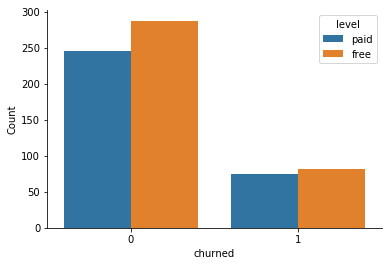

In [12]:
#  df_spark.select(['churn','level','userId']).dropDuplicates().groupby('level')
df_level_pd = df_spark.dropDuplicates(["userId", "level"]).groupby(["churn", "level"]).count().sort("churn").toPandas()
ax =sns.barplot(x='churn', y='count', hue='level', data=df_level_pd)
plt.xlabel('churned')
plt.ylabel('Count')
plt.legend(title='level', loc='best')
sns.despine(ax=ax);

### How page  influe the use's churn behavior
We just saw what happens to customers who have just upgraded, most likely just to renew, maybe because they just were more active

In [13]:
df_churn_pd = df_spark.dropDuplicates(['userId', 'churn', 'page']).groupby(['churn', 'page']).count().toPandas()
df_churn_pd = df_churn_pd.sort_values(by = ['page','churn'],ascending = False)
df_churn_pd

group1= df_churn_pd.groupby(['page','churn']).sum().reset_index()

group2= df_churn_pd.groupby(['page']).sum().reset_index()

p=pd.merge(group1,group2,how='outer',on='page')

p['user_count'] = p['count_y']

p['churned_user_count'] = p['count_x']
p['churned_rate'] = p['churned_user_count']/p['user_count']

p[p['churn_x'] == 1][['page','user_count','churned_user_count','churned_rate']].sort_values(by = 'churned_rate',ascending = False).reset_index().drop(['index'],axis = 1)

,page,user_count,churned_user_count,churned_rate
0,Cancel,99,99,1.000000
1,Cancellation Confirmation,99,99,1.000000
2,Downgrade,301,74,0.245847
3,Submit Upgrade,233,55,0.236052
4,Add Friend,409,95,0.232274
5,Upgrade,315,73,0.231746
6,Thumbs Down,389,89,0.228792
7,Roll Advert,395,90,0.227848
8,Help,360,81,0.225000
9,Thumbs Up,439,98,0.223235


### How number of songs the use listen to influence  uses' churned behavior
We can find the that the uses who churn listen less song than the uses who haven't churn.

/opt/ibm/conda/miniconda3/lib/python3.5/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


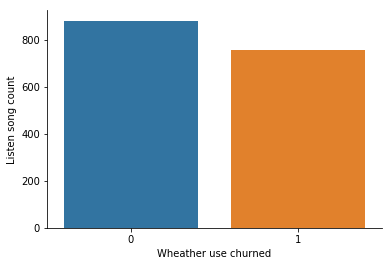

In [52]:
df_song_pd = df_spark.dropDuplicates(['userId', 'churn', 'song']).groupby(['churn']).count().toPandas()

df_churn_pd = df_spark.dropDuplicates(['userId', 'churn']).groupby(['churn']).count().toPandas()

df_song_pd['avg_song_count'] = df_song_pd['count']/df_churn_pd['count']

ax = sns.barplot(data=df_song_pd, x='churn', y='avg_song_count')influence 
plt.xlabel('Wheather use churned')
plt.ylabel('Listen song count')
sns.despine(ax=ax);

### How the number of session influence uses' churned behavior
We can find the that the uses who churn listen less session than the uses who haven't churn.

/opt/ibm/conda/miniconda3/lib/python3.5/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


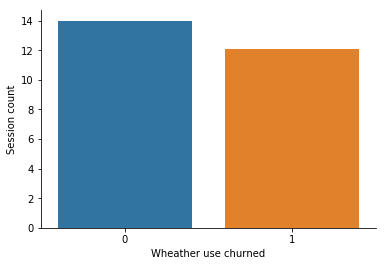

In [58]:
df_session_pd = df_spark.dropDuplicates(['userId', 'churn', 'sessionId']).groupby(['churn']).count().toPandas()

df_session_pd['session_count'] = df_session_pd['count']/df_churn_pd['count']

ax = sns.barplot(data=df_session_pd, x='churn', y='session_count')
plt.xlabel('Wheather use churned')
plt.ylabel('Session count')
sns.despine(ax=ax);

### How dose the average number of songs that users listen to in each session influence users' churned behavior
We see no significant difference, so this will not be used as a feature later

/opt/ibm/conda/miniconda3/lib/python3.5/site-packages/seaborn/categorical.py:598: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
/opt/ibm/conda/miniconda3/lib/python3.5/site-packages/seaborn/categorical.py:826: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


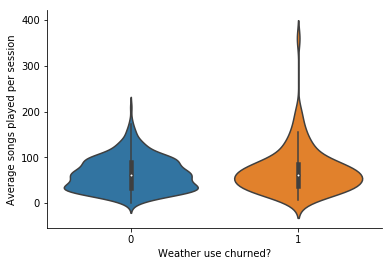

In [16]:
df_song_session_pd = df_spark.where('page == "NextSong"').groupby(['churn', 'userId', 'sessionId']).count()\
    .groupby(['churn', 'userId']).agg({'count':'avg'})\
    .withColumnRenamed('avg(count)', 'song_count_session')\
    .toPandas()

ax = sns.violinplot(x = 'churn', y='song_count_session', data = df_song_session_pd)
plt.xlabel('Weather use churned?')
plt.ylabel('Average songs played per session')
sns.despine(ax=ax);

### The influence of user life cycle on whether users are churned or not
We can find  significantly that the chunrd users have shorter lives than the uses who havn't chunred.

/opt/ibm/conda/miniconda3/lib/python3.5/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


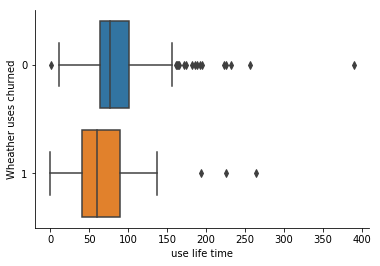

In [19]:
df_lifetime_pd = df_spark \
    .select('userId','registration','ts','churn') \
    .withColumn('lifetime',(df_spark.ts-df_spark.registration)) \
    .groupBy('userId','churn') \
    .agg({'lifetime':'max'}) \
    .withColumnRenamed('max(lifetime)','lifetime') \
    .select('userId', 'churn', (col('lifetime')/86400000).alias('lifetime')) \
    .toPandas()

ax = sns.boxplot(data=df_lifetime_pd, y='churn', x='lifetime', orient='h')
plt.xlabel('use life time')
plt.ylabel('Wheather uses churned')
sns.despine(ax=ax);

# 3. Data Preparation

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

## Feature 1: user paid level


In [6]:
user_paid = df_spark.groupby("userId", "level").agg(max(df_spark.ts).alias("lastTime"))
user_last_level_time = user_paid.groupby("userId").agg(max(user_paid.lastTime).alias("lastTime"))
user_last_level = user_last_level_time.join(user_paid, [user_paid.userId == user_last_level_time.userId, user_last_level_time.lastTime == user_paid.lastTime]).select(user_paid.userId, "level")
user_last_level = user_last_level.replace(["free", "paid"], ["0", "1"], "level")
ft_last_level = user_last_level.select("userId", user_last_level.level.cast("int"))

In [12]:
ft_last_level.show(5)

+------+-----+
|userId|level|
+------+-----+
|    12|    1|
|   147|    0|
|   162|    1|
|200028|    1|
|   238|    1|
+------+-----+
only showing top 5 rows



## Feature 2: user page visit count

In [7]:
# get all the type of page
page_list = [(row['page']) for row in df_spark.select("page").dropDuplicates().collect()]

# must remove the column which will cause data leakage
page_list.remove("Cancel")

page_list.remove("Cancellation Confirmation")

# caculate the total page each user view
df_page_view_count = df_spark.groupby("userId").count()

for page in page_list:
    col_name = "count_" + page.replace(" ", "_")
    page_count = df_spark.filter(df_spark.page==page).groupby("userId").count()
    page_count = page_count.withColumnRenamed("count", col_name).withColumnRenamed("userId", "userIdbak")
    df_page_view_count = df_page_view_count.join(page_count, df_page_view_count.userId==page_count.userIdbak, "left").drop("userIdbak")
ft_page_view_count = df_page_view_count.fillna(0)

In [14]:
ft_page_view_count.show(5)

+------+-----+----------------------+-----------------+----------+---------------+-----------------+------------+-------------------+-----------+--------------+---------------------+----------------+--------------+---------------+----------+-------------+-----------+--------------------+
|userId|count|count_Submit_Downgrade|count_Thumbs_Down|count_Home|count_Downgrade|count_Roll_Advert|count_Logout|count_Save_Settings|count_About|count_Settings|count_Add_to_Playlist|count_Add_Friend|count_NextSong|count_Thumbs_Up|count_Help|count_Upgrade|count_Error|count_Submit_Upgrade|
+------+-----+----------------------+-----------------+----------+---------------+-----------------+------------+-------------------+-----------+--------------+---------------------+----------------+--------------+---------------+----------+-------------+-----------+--------------------+
|100010|  137|                     0|                3|         3|              0|               22|           1|                  0|

## Feature 3: user page visit proportion 

In [10]:
# 创建视图
ft_page_view_count.createOrReplaceTempView("db_page_view_count")
page_list = ft_page_view_count.columns
page_list.remove("userId")
page_list.remove("count")
freq_sql = "select userId"
for page in page_list:
    page_name = page.replace("count", "freq")
    sql_str = ", (" + page + "/(count/100)) as " + page_name
    freq_sql = freq_sql + sql_str
freq_sql = freq_sql + " from db_page_view_count"

ft_page_view_proportion  = spark.sql(freq_sql)

In [51]:
ft_page_view_proportion.show(5)

+------+---------------------+-------------------+------------------+-------------------+-------------------+------------------+-------------------+-------------------+-------------------+--------------------+------------------+-----------------+------------------+-------------------+-------------------+-------------------+-------------------+
|userId|freq_Submit_Downgrade|   freq_Thumbs_Down|         freq_Home|     freq_Downgrade|   freq_Roll_Advert|       freq_Logout| freq_Save_Settings|         freq_About|      freq_Settings|freq_Add_to_Playlist|   freq_Add_Friend|    freq_NextSong|    freq_Thumbs_Up|          freq_Help|       freq_Upgrade|         freq_Error|freq_Submit_Upgrade|
+------+---------------------+-------------------+------------------+-------------------+-------------------+------------------+-------------------+-------------------+-------------------+--------------------+------------------+-----------------+------------------+-------------------+-------------------+---

## Feature 4: how many singers have the user heard

In [11]:
ft_song_count = df_spark.dropDuplicates(['userId', 'churn', 'song']).groupby(['userId']).count().withColumnRenamed('count', 'song_count')
ft_song_count.show(5)

+------+----------+
|userId|song_count|
+------+----------+
|100010|        97|
|200002|       307|
|   296|       110|
|   125|        63|
|   124|      1612|
+------+----------+
only showing top 5 rows



## Feature 5: user session count

In [12]:
ft_session_count = df_spark.dropDuplicates(['userId', 'churn', 'sessionId']).groupby(['userId']).count().withColumnRenamed('count', 'session_count')
ft_session_count.show(5)

+------+-------------+
|userId|session_count|
+------+-------------+
|100010|            2|
|200002|            5|
|   296|            5|
|   125|            3|
|   124|           17|
+------+-------------+
only showing top 5 rows



## Feature 6: The average number of songs t in  session 

In [13]:
ft_song_session = df_spark.where('page == "NextSong"').groupby(['churn', 'userId', 'sessionId']).count()\
    .groupby(['userId']).agg({'count':'avg'})\
    .withColumnRenamed('avg(count)', 'song_count_session')\

ft_song_session.show(5)

+------+------------------+
|userId|song_count_session|
+------+------------------+
|100010|              48.0|
|200002|              62.0|
|   296|              22.4|
|   125|20.666666666666668|
|   124|           114.125|
+------+------------------+
only showing top 5 rows



## Feature 7 user registration days

In [14]:
ft_lifetime = df_spark \
    .select('userId','registration','ts') \
    .withColumn('lifetime',(df_spark.ts-df_spark.registration)) \
    .groupBy('userId') \
    .agg({'lifetime':'max'}) \
    .withColumnRenamed('max(lifetime)','lifetime') \
    .select('userId', (col('lifetime')/86400000).alias('lifetime'))

In [88]:
ft_lifetime.show(10)

+------+------------------+
|userId|          lifetime|
+------+------------------+
|   296| 26.63826388888889|
|100010|14.328449074074074|
|200002| 53.32314814814815|
|   125|105.42211805555556|
|   124| 112.5537962962963|
|     7| 78.02979166666667|
|    51| 18.84582175925926|
|200037| 42.55398148148148|
|   169| 78.84166666666667|
|   205|52.055104166666666|
+------+------------------+
only showing top 10 rows



## Feature 8:The number of artists

In [15]:
ft_artist_count = df_spark.dropDuplicates(["userId", "artist"]).groupby("userId").count().withColumnRenamed("count", "artist_count")

ft_artist_count.show(5)

+------+------------+
|userId|artist_count|
+------+------------+
|100010|          95|
|200002|         288|
|   296|         109|
|   125|          62|
|   124|        1241|
+------+------------+
only showing top 5 rows



## Feature 9: gender


In [16]:
ft_gender = df_spark.dropDuplicates(["userId", "gender"]).replace(["M", "F"], ["0", "1"], "gender").select("userId", col('gender').cast("int"))

ft_gender.show()

+------+------+
|userId|gender|
+------+------+
|   234|     0|
|   188|     1|
|    44|     1|
|   273|     0|
|    46|     1|
|   220|     1|
|    41|     1|
|   186|     0|
|   254|     0|
|   280|     0|
|100035|     1|
|   294|     1|
|    72|     1|
|300023|     1|
|    39|     1|
|   287|     0|
|100010|     1|
|200026|     0|
|   210|     1|
|   207|     0|
+------+------+
only showing top 20 rows



## Label: churn

In [17]:
label_churn = df_spark.dropDuplicates(["userId", "churn"]).select('userId',col('churn').cast('int'))
label_churn.show(5)

+------+-----+
|userId|churn|
+------+-----+
|100010|    1|
|200002|    1|
|   296|    1|
|   125|    0|
|   124|    1|
+------+-----+
only showing top 5 rows



## Merget all the features

In [18]:
allFeatures = [ft_last_level,ft_page_view_count,ft_page_view_proportion,ft_song_count,ft_session_count,ft_song_session,ft_lifetime,ft_artist_count,ft_gender,label_churn]

In [19]:
df_features_all = df_spark.select('userId').dropDuplicates()

In [20]:
def features_merge(df1, df2):
    """
    This function is used to merge the feature using left join
    input: two data frame to be merged
    output: merged dataframe
    """
    df2 = df2.withColumnRenamed("userId", "userIdbak")
    df = df1.join(df2, df1.userId == df2.userIdbak, "left").drop("userIdbak")
    return df

In [21]:
for feature in allFeatures:
    df_features_all = features_merge(df_features_all,feature)

In [106]:
df_features_all.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string, downgrade_event: int, downgrade: int, churn_event: int, churn: int, level: int, count: bigint, count_Submit_Downgrade: bigint, count_Thumbs_Down: bigint, count_Home: bigint, count_Downgrade: bigint, count_Roll_Advert: bigint, count_Logout: bigint, count_Save_Settings: bigint, count_About: bigint, count_Settings: bigint, count_Add_to_Playlist: bigint, count_Add_Friend: bigint, count_NextSong: bigint, count_Thumbs_Up: bigint, count_Help: bigint, count_Upgrade: bigint, count_Error: bigint, count_Submit_Upgrade: bigint, freq_Submit_Downgrade: double, freq_Thumbs_Down: double, freq_Home: double, freq_Downgrade: double, freq_Roll_Advert: double, freq_Logout: double, freq_Save_Settings

In [110]:
df_features_all.show(5)

+------+-----+-----+----------------------+-----------------+----------+---------------+-----------------+------------+-------------------+-----------+--------------+---------------------+----------------+--------------+---------------+----------+-------------+-----------+--------------------+---------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+--------------------+------------------+-----------------+------------------+------------------+------------------+----------+-------------------+----------+-------------+------------------+------------------+------------+------+-----+
|userId|level|count|count_Submit_Downgrade|count_Thumbs_Down|count_Home|count_Downgrade|count_Roll_Advert|count_Logout|count_Save_Settings|count_About|count_Settings|count_Add_to_Playlist|count_Add_Friend|count_NextSong|count_Thumbs_Up|count_Help|count_Upgrade|count_Error|count_Submit_Upgrade|fr

# 5. Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

## 5.1  Data numerically and standardized

In [111]:
df_features_all.groupby('churn').count().show()

+-----+-----+
|churn|count|
+-----+-----+
|    1|   99|
|    0|  349|
+-----+-----+



In [22]:
df_features_all_copy = df_features_all

In [23]:
all_features_list = df_features_all.columns[1:]
for feature in all_features_list:
#     feature_clean = feature.replace("_float","")
    new_feature_name = feature + "_double"
    df_features_all = df_features_all.withColumn(new_feature_name, df_features_all[feature].cast("double"))
    df_features_all = df_features_all.drop(feature)

In [22]:
df_features_all.printSchema()

root
 |-- userId: string (nullable = true)
 |-- level_double: double (nullable = true)
 |-- count_double: double (nullable = true)
 |-- count_Submit_Downgrade_double: double (nullable = true)
 |-- count_Thumbs_Down_double: double (nullable = true)
 |-- count_Home_double: double (nullable = true)
 |-- count_Downgrade_double: double (nullable = true)
 |-- count_Roll_Advert_double: double (nullable = true)
 |-- count_Logout_double: double (nullable = true)
 |-- count_Save_Settings_double: double (nullable = true)
 |-- count_About_double: double (nullable = true)
 |-- count_Settings_double: double (nullable = true)
 |-- count_Add_to_Playlist_double: double (nullable = true)
 |-- count_Add_Friend_double: double (nullable = true)
 |-- count_NextSong_double: double (nullable = true)
 |-- count_Thumbs_Up_double: double (nullable = true)
 |-- count_Help_double: double (nullable = true)
 |-- count_Upgrade_double: double (nullable = true)
 |-- count_Error_double: double (nullable = true)
 |-- cou

In [33]:
df_features_all.write.save('df_features_all_clean_version.csv',format = 'csv',head = True)

In [24]:
def feature_scaling(df):
#     feature_cols = df.drop('userId','churn').columns
    feature_cols = df.drop('userId','churn_double').columns
    assembler = VectorAssembler(inputCols=feature_cols,\
                                outputCol='feature_vector')
    
    df = assembler.transform(df)
    
    minmaxscaler = MinMaxScaler(inputCol="feature_vector", outputCol="features")
    
    minmaxscaler_model = minmaxscaler.fit(df)
    
    scaled_df = minmaxscaler_model.transform(df)
    
    scaled_df = scaled_df.select(scaled_df.churn_double.alias('label'),'features')
#     scaled_df = scaled_df.select('label','features')
    return scaled_df

In [25]:
data_scaled = feature_scaling(df_features_all)

In [136]:
data_scaled.take(1)

[Row(label=1, features=DenseVector([0.0, 0.0137, 0.0, 0.0375, 0.0097, 0.0, 0.1176, 0.0104, 0.0, 0.0, 0.0, 0.004, 0.019, 0.0116, 0.0079, 0.0, 0.125, 0.0, 0.0, 0.0, 0.0985, 0.0657, 0.0, 0.6959, 0.0219, 0.0, 0.0, 0.0, 0.1131, 0.3153, 0.5863, 0.3262, 0.0, 0.1898, 0.0, 0.0, 0.0159, 0.011, 0.1309, 0.038, 0.0265, 1.0]))]

In [34]:
data_scaled.show(1)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  1.0|[0.0,0.0137238836...|
+-----+--------------------+
only showing top 1 row



In [30]:
trainData, validData = data_scaled.randomSplit([0.8, 0.2], seed=42)
trainData = trainData.cache()

In [37]:
trainData.take(1)

[Row(label=1.0, features=DenseVector([0.0, 0.0137, 0.0, 0.0375, 0.0097, 0.0, 0.1176, 0.0104, 0.0, 0.0, 0.0, 0.004, 0.019, 0.0116, 0.0079, 0.0, 0.125, 0.0, 0.0, 0.0, 0.0985, 0.0657, 0.0, 0.6959, 0.0219, 0.0, 0.0, 0.0, 0.1131, 0.3153, 0.5863, 0.3262, 0.0, 0.1898, 0.0, 0.0, 0.0159, 0.011, 0.1309, 0.038, 0.0265, 1.0]))]

In [33]:
trainData.show(1)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  1.0|[0.0,0.0137238836...|
+-----+--------------------+
only showing top 1 row



## 5.2 Modeling and Evaluation 

### logistic regression 
First, we explore the best parameter and find that when elasticNetParam = 0.5 and regParam = 0.05, we obtain the optimal value.</p>
And finally, the accuray = 0.75, the F1 = 0.65

In [36]:
lr =  LogisticRegression()
paramGrid = ParamGridBuilder() \
    .addGrid(lr.elasticNetParam,[ 0.5, 1.0]) \
    .addGrid(lr.regParam,[0.05, 0.1]) \
    .build()

f1_evaluator = MulticlassClassificationEvaluator(metricName='f1')

crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
#                           evaluator=MulticlassClassificationEvaluator(),
                          evaluator=f1_evaluator,
                          numFolds=3)


In [37]:
cvModel_lr = crossval.fit(trainData)
cvModel_lr.avgMetrics

[0.7130454514592424, 0.695338925927717, 0.695338925927717, 0.695338925927717]

In [38]:
def show_result(result_final):
    evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
    print('Test set metrics:')
    print('Accuracy: {}'.format(evaluator.evaluate(result_final, {evaluator.metricName: "accuracy"})))
    print('F-1 Score:{}'.format(evaluator.evaluate(result_final, {evaluator.metricName: "f1"})))

In [40]:
lr_best = LogisticRegression(elasticNetParam=0.5,regParam = 0.05)
lr_best_model = lr_best.fit(trainData)
lr_results = lr_best_model.transform(validData)

In [41]:
show_result(lr_results)

Test set metrics:
Accuracy: 0.7558139534883721
F-1 Score:0.6507007546588633


### GBDT
First, we explore the best parameter and find that when maxDepth = 5 and maxIter = 10, we obtain the optimal value.</p>
And finally, the accuray = 0.75, the F1 = 0.65

In [42]:
gbt = GBTClassifier(maxIter=10,seed=42)

# build paramGrid
paramGrid_gbt = ParamGridBuilder() \
    .addGrid(gbt.maxDepth,[5, 10]) \
    .addGrid(gbt.maxIter, [10,15]) \
    .build()

# set evaluator
f1_evaluator = MulticlassClassificationEvaluator(metricName='f1')

crossval_gbt = CrossValidator(estimator=gbt,
                          estimatorParamMaps=paramGrid_gbt,
                          evaluator=f1_evaluator,
                          numFolds=3)

In [43]:
cvModel_gbt = crossval_gbt.fit(trainData)
cvModel_gbt.avgMetrics

[0.7365377659585715,
 0.7476981600064713,
 0.7424123442184194,
 0.7476981600064713]

In [44]:
gbt_best = GBTClassifier( maxDepth=5,maxIter=15,seed=42)
gbt_best_model = gbt_best.fit(trainData)
gbt_results = gbt_best_model.transform(validData)

In [45]:
show_result(gbt_results)

Test set metrics:
Accuracy: 0.7093023255813954
F-1 Score:0.6790728094057523


### RandomForest
First, we explore the best parameter and find that when impurity = 'gini' and maxDepth = 10, we obtain the optimal value.</p>
And finally, the accuray = 0.75, the F1 = 0.70

In [61]:
rf = RandomForestClassifier(seed=42)

# build paramGrid
paramGrid_rf = ParamGridBuilder() \
    .addGrid(rf.impurity,['entropy', 'gini']) \
    .addGrid(rf.maxDepth,[5, 10]) \
    .build()

# set evaluator
f1_evaluator = MulticlassClassificationEvaluator(metricName='f1')

crossval_rf = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid_rf,
                          evaluator=f1_evaluator,
                          numFolds=3)

In [62]:
cvModel_rf = crossval_rf.fit(trainData)
cvModel_rf.avgMetrics

[0.7318536773245431,
 0.7242687881696135,
 0.7222889333642037,
 0.7398400434611276]

In [63]:
rf_best = RandomForestClassifier(seed=42, maxDepth=10,impurity = 'gini')
rf_best_model = rf_best.fit(trainData)
rf_results = rf_best_model.transform(validData)

In [34]:
show(rf_results)

Test set metrics:
Accuracy: 0.7558139534883721
F-1 Score:0.7006148088746325


### Observed the importance  variables

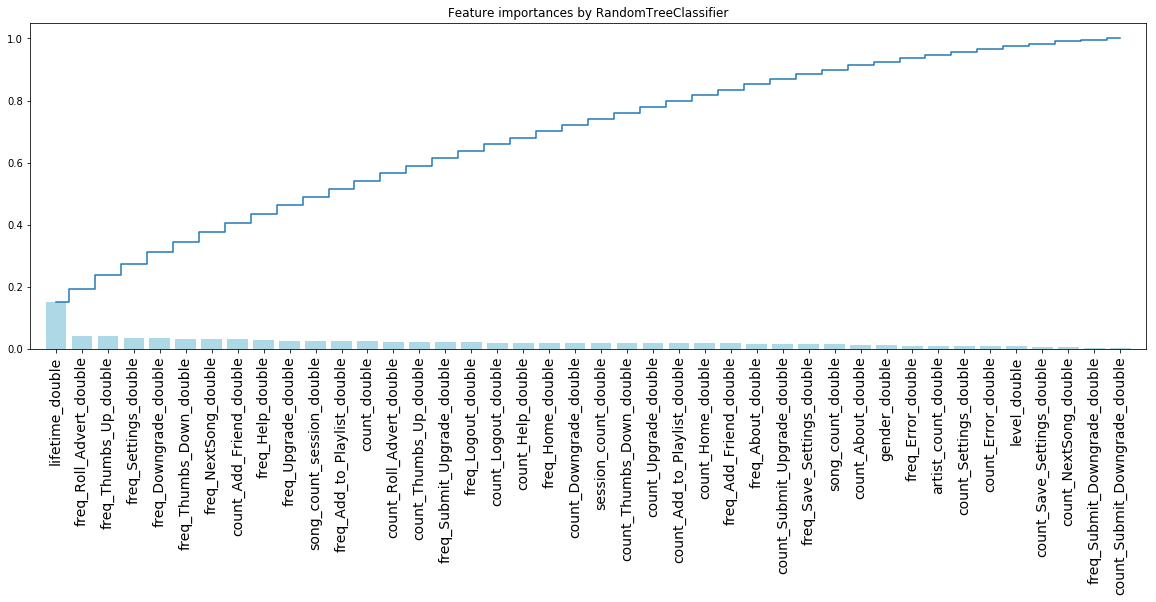

In [66]:

importances = rf_best_model.featureImportances.values

feat_names = df_features_all.columns
feat_names.remove('userId')
feat_names.remove('churn_double')
indices = np.argsort(importances)[::-1]
fig = plt.figure(figsize=(20,6))
plt.title("Feature importances by RandomTreeClassifier")
plt.bar(range(len(indices)), importances[indices], color='lightblue',  align="center")
plt.step(range(len(indices)), np.cumsum(importances[indices]), where='mid', label='Cumulative')
plt.xticks(range(len(indices)), np.array(feat_names)[indices], rotation='vertical',fontsize=14)
plt.xlim([-1, len(indices)])
plt.show()

## 5.3 conclusion 
After the test above, we finally choose the random forest as the final model, with its accurcy = 0.75 and f1= 0.7.<p/>
The factors that have the greatest impact on user churn are: <p/>
lifetime,freq_Roll_advert,freq_Thumbs_Up,freq_Settings,freq_Downgrade,freq_Thumbs_Down,freq_NextSong,count_Add_Friend,Freq_Help,Freq_upgrade

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.

User behavior data is often very large and difficult to complete using traditional analysis methods, so it needs to be done through spark.Pyspark is a combination of the python language and spark that handles these issues well.Considering the problem of computing resources, only 248M of the total 12G data was used in this paper, with a total of 488 users.

**Problem 1**. Not all data are used, and the deviation of sampling may lead to the deviation of analysis conclusion.<br>
**Follow-up work**. Use full 12G data for analysis and mining.

**Problem 2**. Abnormal information haven't been clean.Our purpose is to analyze normal users, but there are some black users on the market who use fake mobile phones for illegal behavior, or other abnormal users.Their behaviors may affect our analysis and judgment,so should be eliminated.<br>
**Follow-up work**. Detected and delete abnormal data.

**Problem 3**. More feature engineering.We only carried out a simple feature work, but there are more features to explore, such as users often both thumb up and often thumb down, this type of users may be more fiery personality, so it is easier to some problems and loss.This type of feature can be further explored.<br>
**Follow-up work**. Explored more features.